# Batch (parallel) Demand Forecasting using PyTorch Forecasting


**Batch training** and tuning are common tasks in machine learning use-cases. They require training simple models, on data batches, typcially corresponding to different locations, products, etc. Batch training can take less time to process all the data at once, but only if those batches can run in parallel!

This notebook showcases how to conduct batch training using forecast algorithms [Prophet](https://github.com/facebook/prophet) and [ARIMA](https://github.com/Nixtla/statsforecast). **Prophet** is a popular open-source library developed by Facebook and designed for automatic forecasting of univariate time series data. **ARIMA** is an older, well-known algorithm for forecasting univariate time series at less fine-grained detail than Prophet.

![Batch training diagram](../../data/examples/images/batch-training.svg)

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

For the training, we will train a separate forecasting model to predict #pickups at each location in NYC at daily level for the next 28 days. Specifically, we will use the `pickup_location_id` column in the dataset to group the dataset into data batches. Then we will conduct an experiment for each location, to find the best either Prophet or ARIMA model, per location.

# Contents

In this this tutorial, you will learn about:
 1. [Define how to load and prepare Parquet data](#prepare_data)
 2. [Define your Ray Tune Search Space and Search Algorithm](#define_search_space2)
 3. [Define a Trainable (callable) function](#define_trainable2)
 4. [Run batch training with Ray Tune](#run_tune_search2)
 5. [Load a model from checkpoint and create a forecast](#load_checkpoint2)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](https://docs.ray.io/en/latest/tune/key-concepts.html) page for Ray Tune.
```

Let us start by importing a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [1]:
import os
import typing
num_cpu = os.cpu_count()

print(f"Number of CPUs in this system: {num_cpu}")
from typing import Tuple, List, Union, Optional, Callable
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np

print(f"numpy: {np.__version__}")
import matplotlib.pyplot as plt

%matplotlib inline
# import scipy

# print(f"scipy: {scipy.__version__}")
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds

print(f"pyarrow: {pyarrow.__version__}")


Number of CPUs in this system: 8
numpy: 1.23.5
pyarrow: 10.0.1


In [2]:
# import GPUtil #GPU status from NVIDA GPUs
# len(GPUtil.getGPUs())

In [3]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2022-12-17 18:12:25,793	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-12-17 18:12:25,794	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 172.31.246.51:9031...
2022-12-17 18:12:25,839	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_bv6cqua3a9m1ir4yiuzkwmrw/services?redirect_to=dashboard 


Python version:,3.9.12
Ray version:,2.2.0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_bv6cqua3a9m1ir4yiuzkwmrw/services?redirect_to=dashboard


In [4]:
print(ray.cluster_resources())

{'CPU': 8.0, 'object_store_memory': 9135416524.0, 'node:172.31.246.51': 1.0, 'memory': 18270833051.0}


In [5]:
# import forecasting libraries
# PyTorch, PyTorch Lightning, and PyTorch Forecasting
import torch  #Pytorch
import pytorch_lightning as pl  #PyTorch Lightning convenience APIs for PyTorch
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_forecasting as ptf #PyTorch Forecasting convenience APIs for PyTorch Lightning
pl.seed_everything(415)  # Set global random seed

# PyTorch visualization uses Tensorboard
# import tensorflow as tf #Tensorflow
import tensorboard as tb  #Tensorboard
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile  #compatibility for PyTorch

print(f"torch: {torch.__version__}")
print(f"PyTorch Lightning: {pl.__version__}")
print(f"pytorch forecasting: {ptf.__version__}")
print(f"tensorboard: {tb.__version__}")

# import ray libraries
import ray_lightning
from ray_lightning import RayStrategy
from ray_lightning.tune import get_tune_resources, TuneReportCheckpointCallback
from ray import air, tune
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
# from ray.air import session
# from ray.air.checkpoint import Checkpoint

# print(f"ray_lightning: {ray_lightning.__version__}")

Global seed set to 415


torch: 1.13.1+cu117
PyTorch Lightning: 1.6.5
pytorch forecasting: 0.10.3
tensorboard: 2.11.0


In [6]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False


def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)


# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = True

## Define how to load and prepare Parquet data <a class="anchor" id="load_data"></a>

First, we need to load some data. Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adapter is faster than pandas read_parquet, even using engine=pyarrow.
```

In [7]:
# Define some global variables.
TARGET = "trip_duration"
FORECAST_LENGTH = 28
MAX_DATE = datetime(2019, 6, 30)
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

# Obtain all location IDs
all_location_ids = (
    pq.read_table(s3_files[0], columns=["pickup_location_id"])[
        "pickup_location_id"
    ]
    .unique()
    .to_pylist()
)
# drop [264, 265]
all_location_ids.remove(264)
all_location_ids.remove(265)

# Use smoke testing or not.
starting_idx = -2 if SMOKE_TEST else 0
# TODO: drop location 199 to test error-handling before final git checkin
sample_locations = [141, 229, 173] if SMOKE_TEST else all_location_ids

# Display what data will be used.
s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")

NYC Taxi using 2 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/05/data.parquet/359c21b3e28f40328e68cf66f7ba40e2_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/06/data.parquet/ab5b9d2b8cc94be19346e260b543ec35_000000.parquet']
Locations: [141, 229, 173]


In [8]:
# Function to read a pyarrow.Table object using pyarrow parquet
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    # parse out min expected date
    part_zero = "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/"
    split_text = file.split(part_zero)[1]
    min_year = split_text.split("/")[0]
    min_month = split_text.split("/")[1]
    string_date = min_year + "-" + min_month + "-" + "01" + " 00:00:00"
    min_date = datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S")

    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">", min_date),
            ("pickup_at", "<=", MAX_DATE),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("pickup_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df


# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    
    # PyTorch Forecasting expects integer counter 'time_idx' per timeseries
    # PyTorch Forecasting expects unique_id to be type string
    # PyTorch Forecasting expects target value to be type float

    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]

    # truncate time hourly
    df["pickup_at"] = df["pickup_at"].dt.to_period("H").dt.to_timestamp()
    # add day_hour as a new feature
    df["day_hour"] = (
        df["pickup_at"].dt.day.astype(str)
        + "_"
        + df["pickup_at"].dt.hour.astype(str)
    )
    # create groupby key
    df["pickup_location_id"] = df["pickup_location_id"].astype(str)
    df["loc_year_month_day_hour"] = (
        df["pickup_location_id"]
        + "_"
        + df["pickup_at"].astype(str)
    )
    # add target_value quantity for groupby count later
    df["trip_quantity"] = 1.0
    # drop unnecessary columns
    df.drop(
        [
            "dropoff_at",
            "pickup_at",
            "dropoff_location_id",
            "fare_amount",
            "passenger_count",
            "trip_distance",
            "trip_duration",
        ],
        axis=1,
        inplace=True,
    )

    # groupby aggregregate
    g = df.groupby("loc_year_month_day_hour").agg(
        {"pickup_location_id": min, "day_hour": min, "trip_quantity": sum}
    ).reset_index()
    # add 'time_idx'
    g.reset_index(inplace=True, drop=False)
    g.rename(columns={"index": "time_idx"}, inplace=True)
    g['time_idx'] = g['time_idx'].astype('int32')
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g["trip_quantity"] > 2].copy()

    # Drop groupby variable since we do not need it anymore
    g.drop(["loc_year_month_day_hour"], axis=1, inplace=True)

    return g


def prepare_data(sample_location_id: np.int32) -> pd.DataFrame:

    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(
            f"Location {sample_location_id} has only {df_raw.shape[0]} rows"
        )
        session.report(dict(error=None))
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        session.report(dict(error=None))
        return None
    else:
        return df

## Define your Ray Tune Search Space and Search Algorithm <a class="anchor" id="define_search_space"></a>

In this notebook, we will use Ray Tune to run parallel training jobs per pickup location. The training jobs will be defined using a search space and simple grid search. Depending on your need, fancier search spaces and search algorithms are possible with Tune.

**First, define a search space of experiment trials to run.**
> The typical use case for Tune search spaces are for hyperparameter tuning. In our case, we are defining a Tune search space in a way to allow for training jobs to be conducted automatically. Each training job will run on a different data partition (taxi pickup location) and use a different algorithm.

**Next, define a search algorithm.**  

```{tip}
Common search algorithms include grid search, random search, and Bayesian optimization. For more details, see [Working with Tune Search Spaces](https://docs.ray.io/en/master/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial). Deciding the best combination of search space and search algorithm is part of the art of being a Data Scientist and depends on the data, algorithm, and problem being solved.
```

Ray Tune will use the search space and search algorithm to generate multiple configurations, each of which will be evaluated in a separate Trial on a Ray Cluster. Ray Tune will take care of orchestrating those Trials automatically. Specifically, Ray Tune will pass a config dictionary to each partition and make a Trainable function call.

**Below, we define our search space consists of:**
- Different algorithms, either:
  - Prophet with [multiplicative or additive](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) seasonal effects 
  - AutoARIMA.
- Some or all NYC taxi pick-up locations.

For Tune search algorithm, we want to run *grid search*, meaning we want to run an experiment for every possible combination in the search space. What this means is every algorithm will be applied to every NYC Taxi pick-up location.

In [9]:
# TODO: clean up this section.  
# Want config closer to where you call function.  Easier to debug.

# # 1. Define a search space.
# search_space = {
#     "batch_size": tune.grid_search([128])  #[128, 64])
# }

## Define a Trainable (callable) function <a class="anchor" id="define_trainable"></a>

📈 Typically when you are running Data Science experiments, you want to be able to keep track of summary metrics for each trial, so you can decide at the end which trials were best. That way, you can decide which model to deploy.

🇫 Next, we define a trainable function in order to train and evaluate a Prophet model on a data partition. This function will be called in parallel by every Tune trial. Inside this trainable function, we will:
- Add detailed metrics we want to report (each model's loss or error). 
- Checkpoint each model for easy deployment later.

📖 **The metrics defined inside the trainable function will appear in the Ray Tune experiment summary table.**
```{tip}
Ray Tune has two ways of defining a trainable, namely the [Function API](https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs) and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

**In the cell below, we define a "Trainable" function called `train_model()`**.
- The input is a config dictionary argument. 
- The output can be a simple dictionary of metrics which will be reported back to Tune.
- We will [checkpoint](https://docs.ray.io/en/master/ray-air/key-concepts.html#checkpoints) save each model in addition to reporting each trial's metrics.
- Since we are using **grid search**, this means `train_model()` will be run *in parallel for every permutation* in the Tune search space!

In [10]:
# Convert pandas data to PyTorch tensors.
def convert_pandas_pytorch_timeseriesdata(
    input_data_pandas_df:pd.DataFrame, 
    config:dict
) -> typing.Union['pytorch_forecasting.data.timeseries.TimeSeriesDataSet',
                  'torch.utils.data.dataloader.DataLoader']:

    """Converts pandas dataframe into TimeSeries folded tensors following 
       the backtesting technique.  A generator for doing the folding is 
       per batch also created.  One for the training data.  
       Another for the validation data.  

    Inputs:
        pd.DataFrame: All the input data
        dict: config is a configuration file containing hard-coded settings.

    Returns:
        'pytorch_forecasting.data.timeseries.TimeSeriesDataSet': training data
        'torch.utils.data.dataloader.DataLoader': training data loader
        'torch.utils.data.dataloader.DataLoader': validation data loader
    """
    
    # specify data parameters
    FORECAST_HORIZON = config.get("forecast_horizon", 168)
    CONTEXT_LENGTH = config.get("context_length", 63)
    BATCH_SIZE = config.get("batch_size", 32)
    NUM_TRAINING_WORKERS = config.get("num_training_workers", 4)
    id_col_name = "pickup_location_id"
    target_value = "trip_quantity"
    
    the_df = input_data_pandas_df.copy()
    
    # define forecast horizon and training cutoff
    max_prediction_length = FORECAST_HORIZON  #decoder length = 1 week forecast horizon
    max_encoder_length = CONTEXT_LENGTH  # window or context length
    training_cutoff = the_df["time_idx"].max() - max_prediction_length 

    # convert pandas to PyTorch tensor
    training_data = ptf.data.TimeSeriesDataSet(
        the_df[lambda x: x.time_idx <= training_cutoff],
        allow_missing_timesteps=True,
        time_idx="time_idx",
        target=target_value,
        group_ids=[id_col_name],
        min_encoder_length=5,  # min 5 historical values must exist
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=[id_col_name],
        # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
        static_reals=[],
        time_varying_known_categoricals=["day_hour"],
        # group of categorical variables can be treated as one variable
        # variable_groups={"special_days": special_days},  
        time_varying_known_reals=["time_idx", ],
                            # "mean_item_loc_weekday",
                            # "binned_max_item"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[target_value,],

        # https://pytorch-forecasting.readthedocs.io/en/v0.2.4/_modules/pytorch_forecasting/data.html
        target_normalizer=ptf.data.GroupNormalizer(
            groups=["pickup_location_id"], 
            transformation="softplus"  #forces positive values
        ), 
        add_relative_time_idx=True, # add as feature
        add_target_scales=True, # add avg target_value as feature
        add_encoder_length=True, # add as feature
    )
    
    # create PyTorch dataloader for training
    train_loader = training_data\
                        .to_dataloader(
                            train=True, 
                            batch_size=BATCH_SIZE, 
                            num_workers=NUM_TRAINING_WORKERS)
    
    # create validation PyTorch data 
    # (predict=True) means make do inference using the validation data
    val_dataset = ptf.data.TimeSeriesDataSet\
                    .from_dataset(
                        training_data, 
                        data=the_df, 
                        predict=True, 
                        stop_randomization=True)

    # create PyTorch dataloaders for inference on validation data
    validation_loader = val_dataset\
                    .to_dataloader(
                        train=False, 
                        batch_size=BATCH_SIZE * 10, 
                        num_workers=NUM_TRAINING_WORKERS)
    
    # return original df converted to PyTorch tensors, and pytorch loaders
    return training_data, train_loader, validation_loader

def evaluate_model(y_actual:'torch.Tensor', 
             y_quantiles:'torch.Tensor', 
             quantile_list:list)->'torch.Tensor':
    """Calculate weighted quantile loss given actuals, quantile predictions,
       and list of desired quantiles to average over.
    Inputs:
        'torch.Tensor': y_actual is a tensor of actual values 
        'torch.Tensor': y_quantiles is a tensor of quantile predictions
        'list': List of quantiles to average over

    Returns:
        'torch.Tensor': weighted quantile loss over all the desired quantiles
    """

    assert not y_actual.requires_grad
    assert y_quantiles.size(0) == y_actual.size(0)
    
    all_losses = []
    for i, q in enumerate(quantile_list):
        sum_actuals = torch.sum(torch.abs(y_actual[i]))
        errors = torch.abs(y_actual[i] - y_quantiles[i][:, i])
        all_losses.append(
            torch.where(y_quantiles[i][:, i] > y_actual[i],
                        (1-q) * errors, 
                        q * errors ).unsqueeze(1))
        
        if torch.is_nonzero(sum_actuals):
            all_losses[i] = torch.sum(all_losses[i]).div(sum_actuals)
        else:
            all_losses[i] = torch.empty_like(all_losses[i])
    
    WQL = torch.mean(torch.stack(all_losses), dim=0)
    return WQL
    
# Define a calling function to read data, define model, train it
def train_ptf(config: dict,
              strategy: 'ray_lightning.ray_ddp.RayStrategy',
              train_dataset: 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet',
              train_loader: 'torch.utils.data.dataloader.DataLoader',
              validation_loader: 'torch.utils.data.dataloader.DataLoader',) -> typing.Union[
                'torch.utils.data.dataloader.DataLoader',
                'pytorch_lightning.trainer.trainer.Trainer',
                'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer',
                str]:
    """Define a calling function to read data, define a model and train it.

    Inputs:
        dict: configuration dictionary with hard-coded runtime values

    Returns:
        'torch.utils.data.dataloader.DataLoader': validation data loader
        'pytorch_lightning.trainer.trainer.Trainer': trainer for fitting the model
        'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer': trained model
        str: path where Pytorch Forecasting model is stored
    """
    
    # Create your PTF model.
    model = ptf.models.TemporalFusionTransformer.from_dataset(
        train_dataset,
        learning_rate=config.get("lr", 0.01),
        hidden_size=config.get("hidden_size", 40), # num neurons in each layer, bigger runs more slowly
        # lstm_layers=HIDDEN_LAYERS, #LSTM layers=1 #default=1 for tft architecture
        attention_head_size=config.get("attention_head_size", 4),  #default 4 cells in LSTM layer
        dropout=config.get("droupout", 0.1),
        hidden_continuous_size=config.get("hidden_continuous_size", 1),  #similar to categorical embedding size
        # 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
        # output_size=7,  
        # optimizer loss metric
        loss=ptf.metrics.QuantileLoss(),
        reduce_on_plateau_patience=4, # reduce learning automatically
    )
    print(f"Number of parameters in network: {model.size()/1e3:.1f}k")
    
    # Configure early stopping.
    early_stop_callback = \
        pl.callbacks.EarlyStopping(monitor="val_loss", 
                      min_delta=1e-4, 
                      patience=10, 
                      verbose=False, 
                      mode="min")
   
    # Create the Tune Reporting Callback
    metrics = {"loss": "val_loss"}
    callbacks = [
                 early_stop_callback, 
                 TuneReportCheckpointCallback(
                     metrics, 
                     on="validation_end")]

    # configure PyTorch trainer with Ray Lightning plugin
    trainer = pl.Trainer(
        max_epochs=config.get("epochs", 30),
        gradient_clip_val=0.1, 
        limit_train_batches=config.get("limit_train_batches", 30),  
        callbacks=callbacks,
        strategy=strategy, 
        # Note: Suggest always use fast_mode, uses Tune logging instead of PTF logging
        fast_dev_run=True,
    )
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=validation_loader,
    )
    
    # Error saving air checkpoints.
    ## ERROR MESSAGE ##
    # /home/ray/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:391: 
    # LightningDeprecationWarning: The `Callback.on_pretrain_routine_end` hook has been deprecated 
    # in v1.6 and will be removed in v1.8. Please use `Callback.on_fit_start` instead.
    
#     # Define a model checkpoint using AIR API.
#     # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
#     checkpoint = ray.air.checkpoint.Checkpoint.from_dict(
#         {
#             "model": model,
#         }
#     )
        
#     # Save checkpoint and report back metrics, using ray.air.session.report()
#     # The metrics you specify here will appear in Tune summary table.
#     # They will also be recorded in Tune results under `metrics`.
#     session.report(metrics, checkpoint=checkpoint)


## Create and train a baseline model

In [11]:
%%time

# specify config parameters for baseline model
num_training_workers = min(num_cpu - 2, 32)
FORECAST_CONFIG = {"forecast_horizon": 168, "context_length": 63,
          "num_gpus":0, "batch_size": 128, 
          "num_training_workers": num_training_workers,
         }

# Test reading data pandas.
sample_location_id = sample_locations[0]
df = prepare_data(sample_location_id)
print(df.shape)
print(df.sample(5))
print(df.dtypes)

# convert data from pandas to PyTorch tensors
print(f"Input data type: {type(df)}")
train_dataset, train_loader, validation_loader = convert_pandas_pytorch_timeseriesdata(
    df, FORECAST_CONFIG
)
print(f"Converted data type: {type(train_dataset)}")

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(validation_loader)])
baseline_predictions = ptf.models.Baseline().predict(validation_loader)

## EVALUATE THE BASELINE MODEL
# print MAE
baseline_error = (actuals - baseline_predictions).abs().mean()
print(f"baseline model MAE: {baseline_error}")


(1440, 4)
      time_idx pickup_location_id day_hour  trip_quantity
606        606                141     26_6           38.0
1284      1284                141    23_12          250.0
1072      1072                141    14_16          224.0
1395      1395                141     28_3           41.0
55          55                141      3_7          387.0
time_idx                int32
pickup_location_id     object
day_hour               object
trip_quantity         float64
dtype: object
Input data type: <class 'pandas.core.frame.DataFrame'>
Converted data type: <class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>


/home/ray/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/ray/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


baseline model MAE: 102.18452453613281
CPU times: user 4.39 s, sys: 1.34 s, total: 5.73 s
Wall time: 4.88 s


## Run batch training on Ray Tune <a class="anchor" id="run_tune_search"></a>


**Now we are ready to kick off a Ray Tune experiment!**  

Recall what we are doing, high level, is training several different models per pickup location. We are using Ray Tune so we can run all these trials in parallel on a Ray cluster. At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**In the cell below, we use AIR configs and run the experiment using `tuner.fit()`.** 

Tune will report on experiment status, and after the experiment finishes, you can inspect the results. 

- In the cell below, we use the default resources config which is 1 CPU core for each task. For more information about configuring resource allocations, see [A Guide To Parallelism and Resources](https://docs.ray.io/en/master/tune/tutorials/tune-resources.html#tune-parallelism). 

- In the AIR config below, we have specified a local directory `my_Tune_logs` for logging instead of the default `~/ray_results` directory. Giving your logs a project name makes them easier to find. Also giving a relative path, means you can see your logs inside the Jupyter browser. Learn more about logging Tune results at [How to configure logging in Tune](https://docs.ray.io/en/master/tune/tutorials/tune-output.html#tune-logging).

- Tune can [retry failed experiments automatically](https://docs.ray.io/en/master/tune/tutorials/tune-stopping.html#tune-stopping-guide), as well as entire experiments. This is necessary in case a node on your remote cluster fails (when running on a cloud such as AWS or GCP).

💡 Right-click on the cell below and choose "Enable Scrolling for Outputs"! This will make it easier to view, since model training output can be very long!

**Setting SMOKE_TEST=False, running on Anyscale: 771 models, using 18 NYC Taxi S3 files dating from 2018/01 to 2019/06 (split into partitions approx 1GiB each), were simultaneously trained on a 7-node AWS cluster of [m5.4xlarges](https://aws.amazon.com/ec2/instance-types/m5/), within 40 minutes.**

In [12]:
# STEP 1. Define a search space of all config parameters, including the Tune ones
FORECAST_CONFIG = {
    "forecast_horizon": 168,
    "context_length": 63,
    "num_gpus": 0,
    "num_training_workers": num_training_workers,
#     "batch_size": 128,     
    "batch_size": tune.grid_search([128, 64]), 
    "epochs": 2,
    "lr": 0.05,
    "hidden_size": 20,
    "dropout": 0.1,
    # "dropout": tune.choice([0, 0.05, 0.1]),
    "hidden_continuous_size": 4,
    "attention_head_size": num_training_workers,
    "limit_train_batches": 1, #0.25,
}

# STEP 2. Specify search strategy: algorithm + scheduler
# Select scheduler https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/
scheduler = ASHAScheduler(
    max_t=FORECAST_CONFIG['epochs'],
    grace_period=1,
    reduction_factor=2)

# STEP 3. Customize scaling 
num_training_workers = min(num_cpu - 2, 32)
strategy = RayStrategy(num_workers=num_training_workers, 
                       num_cpus_per_worker=1, 
                       use_gpu=False,
                        # add this to skip warnings
                        # https://github.com/PyTorchLightning/pytorch-lightning/discussions/6761
                        find_unused_parameters=False,)

# Optional to pass parameters. Wrap Callable train function inside tune.with_parameters()
# By default Callable function accepts only 1 input parameter called "config"
train_fn_with_parameters = \
    tune.with_parameters(train_ptf,
                         strategy=strategy,
                         train_dataset=train_dataset, 
                         train_loader=train_loader, 
                         validation_loader=validation_loader)

# STEP 4. Run the experiment with Ray Tune.
# Use Ray 2.2 Tune APIs
# https://docs.ray.io/en/latest/tune/examples/tune-pytorch-lightning.html
start = time.time()

tuner = tune.Tuner(
        tune.with_resources(
            train_fn_with_parameters,
            resources=get_tune_resources(num_workers=num_training_workers),
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
#             scheduler=scheduler,
        ),
        run_config=air.RunConfig(
            name="ptf_nyc",
        ),
        param_space=FORECAST_CONFIG,
    )

results = tuner.fit()
 
total_time_taken = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"Finished in: {(time.time()-start)/60} minutes")

# With ASHA
# Total number of models: 2
# Finished in: 3.0699266950289408 minutes

# Without ASHA
# Total number of models: 2
# Finished in: 0.6272321343421936 minutes


(train_ptf pid=51359) Number of parameters in network: 39.6k


(train_ptf pid=51359) GPU available: False, used: False
(train_ptf pid=51359) TPU available: False, using: 0 TPU cores
(train_ptf pid=51359) IPU available: False, using: 0 IPUs
(train_ptf pid=51359) HPU available: False, using: 0 HPUs
(train_ptf pid=51359) Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
(train_ptf pid=51359) `Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
(train_ptf pid=51359) `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
(train_ptf pid=51359) `Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
(train_ptf pid=51359) `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
(train_ptf pid=51359) `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
(RayExecutor pid=51472) /home/ray/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: Lightni

(scheduler +22s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +22s) Adding 1 node(s) of type worker-node-type-0.


(RayExecutor pid=51473) Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/6
(RayExecutor pid=51475) Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/6
(RayExecutor pid=51474) Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/6
(RayExecutor pid=51477) Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/6
(RayExecutor pid=51476) Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/6
(RayExecutor pid=51472) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=51472) distributed_backend=gloo
(RayExecutor pid=51472) All distributed processes registered. Starting with 6 processes
(RayExecutor pid=51472) ----------------------------------------------------------------------------------------------------
(RayExecutor pid=51472) 
(RayExecutor pid=51472) /home/ray/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback ho

Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.31s/it, loss=105, v_num=, train_loss_step=105.0]
(RayExecutor pid=51472) 
Validation: 0it [00:00, ?it/s] 
(RayExecutor pid=51472) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it, loss=105, v_num=, train_loss_step=105.0]


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_ptf_6f9ca_00000,2022-12-17_18-12-57,True,,006815e4ed584d0287095dbb51c9bf3a,0_batch_size=128,ip-172-31-246-51,1,88.0593,172.31.246.51,51359,True,17.4611,17.4611,17.4611,1671329577,0,,1,6f9ca_00000,0.00283813
train_ptf_6f9ca_00001,2022-12-17_18-13-15,True,,006815e4ed584d0287095dbb51c9bf3a,1_batch_size=64,ip-172-31-246-51,1,104.994,172.31.246.51,51359,True,16.8082,16.8082,16.8082,1671329595,0,,1,6f9ca_00001,0.00283813


Epoch 0: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it, loss=105, v_num=, train_loss_step=105.0, val_loss=88.10, train_loss_epoch=104.0]
(train_ptf pid=51359) Number of parameters in network: 39.6k


(train_ptf pid=51359) GPU available: False, used: False
(train_ptf pid=51359) TPU available: False, using: 0 TPU cores
(train_ptf pid=51359) IPU available: False, using: 0 IPUs
(train_ptf pid=51359) HPU available: False, using: 0 HPUs
(train_ptf pid=51359) Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
(train_ptf pid=51359) `Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
(train_ptf pid=51359) `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
(train_ptf pid=51359) `Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
(train_ptf pid=51359) `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
(train_ptf pid=51359) `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
(RayExecutor pid=54271) /home/ray/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: Lightni

Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.28s/it, loss=114, v_num=, train_loss_step=114.0]
(RayExecutor pid=54271) 
Validation: 0it [00:00, ?it/s] 
(RayExecutor pid=54271) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(RayExecutor pid=54271) 
Epoch 0: 100%|██████████| 2/2 [00:06<00:00,  3.33s/it, loss=114, v_num=, train_loss_step=114.0, val_loss=105.0, train_loss_epoch=114.0]


2022-12-17 18:13:16,175	INFO tune.py:762 -- Total run time: 41.48 seconds (41.32 seconds for the tuning loop).


Total number of models: 2
Finished in: 0.6917209108670552 minutes


In [13]:
[print(i.config) for i in results]

{'forecast_horizon': 168, 'context_length': 63, 'num_gpus': 0, 'num_training_workers': 6, 'batch_size': 128, 'epochs': 2, 'lr': 0.05, 'hidden_size': 20, 'dropout': 0.1, 'hidden_continuous_size': 4, 'attention_head_size': 6, 'limit_train_batches': 1}
{'forecast_horizon': 168, 'context_length': 63, 'num_gpus': 0, 'num_training_workers': 6, 'batch_size': 64, 'epochs': 2, 'lr': 0.05, 'hidden_size': 20, 'dropout': 0.1, 'hidden_continuous_size': 4, 'attention_head_size': 6, 'limit_train_batches': 1}


[None, None]

In [14]:
# get a list of training loss errors
loss = [i.metrics.get("loss", 10000.0) for i in results]

# get a list of model params
batch_size = [i.config["batch_size"] for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(loss, batch_size, checkpoints),
    columns=["loss", "batch_size", "checkpoint"],
)
print(results_df.dtypes)
results_df.head(8)

loss          float64
batch_size      int64
checkpoint     object
dtype: object


,loss,batch_size,checkpoint
0,88.059303,128,Checkpoint(local_path=/home/ray/ray_results/pt...
1,104.994011,64,Checkpoint(local_path=/home/ray/ray_results/pt...


In [15]:
# results_df.describe(include="all")

In [25]:
# Get model error for the best model
# TODO: Not exact comparison -baseline was MAE vs tuned was WQL
best_model_error = results_df.loss.min()
print("#########")
print(f"Baseline error: {baseline_error}")
print(f"Best tuned error: {best_model_error}")
print("#########")
print()

# Get model path for the best model
best_model_path = results_df.iloc[0, -1:][0]
best_model_path = str(best_model_path).split("local_path=")[1]
best_model_path = best_model_path.split(")")[0] + "/checkpoint"

# Restore a model from checkpoint
best_model = ptf.models.TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Restored model type: {type(best_model)}")



#########
Baseline error: 102.18452453613281
Best tuned error: 88.0593032836914
#########

Restored model type: <class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>
(scheduler +6m24s) Removing 1 nodes of type worker-node-type-0 (idle).
(scheduler +6m36s) Resized to 8 CPUs.


In [17]:
# TODO - fix this.
# calculate WQL
print(f"available quantiles: {best_model.loss.quantiles}")
# note: to get a single item quantile prediction:
# example: quantile p50 for itemid="140"
# y_quantiles[1].detach().cpu()[43, : x["decoder_lengths"][43]] 
# raw predictions are a dictionary from which quantiles can be extracted
raw_predictions, x = best_model.predict(validation_loader, mode="raw", return_x=True)
# desired_quantiles = [0.25, 0.5, 0.75]
# y_quantiles = best_model.to_quantiles(raw_predictions, desired_quantiles)
# WQL = evaluate_model(actuals, y_quantiles, desired_quantiles)
# print(f"Mean WQL over quantiles {desired_quantiles}: {WQL}")

# Cell In[82], line 116, in evaluate_model(y_actual, y_quantiles, quantile_list)
#     114 all_losses = []
#     115 for i, q in enumerate(quantile_list):
# --> 116     sum_actuals = torch.sum(torch.abs(y_actual[i]))
#     117     errors = torch.abs(y_actual[i] - y_quantiles[i][:, i])
#     118     all_losses.append(
#     119         torch.where(y_quantiles[i][:, i] > y_actual[i],
#     120                     (1-q) * errors, 
#     121                     q * errors ).unsqueeze(1))
# IndexError: index 1 is out of bounds for dimension 0 with size 1

available quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


## Load a model from checkpoint and create a forecast  <a class="anchor" id="load_checkpoint"></a>

```{tip}
[Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) make batch inference easy since they have internal logic to parallelize the inference.
```
  
Finally, we will restore the best and worst models from checkpoint and inspect the forecasts. Prophet includes a convenient plot library which displays actual data along with backtest predictions and confidence intervals and future forecasts. With ARIMA, you have to create a prediciton manually.

- We will easily obtain AIR Checkpoint objects from the Tune results. 
- We will restore a Prophet or ARIMA model directly from checkpoint, and demonstrate it can be used for prediction.


In [18]:
sample_locations

[141, 229, 173]

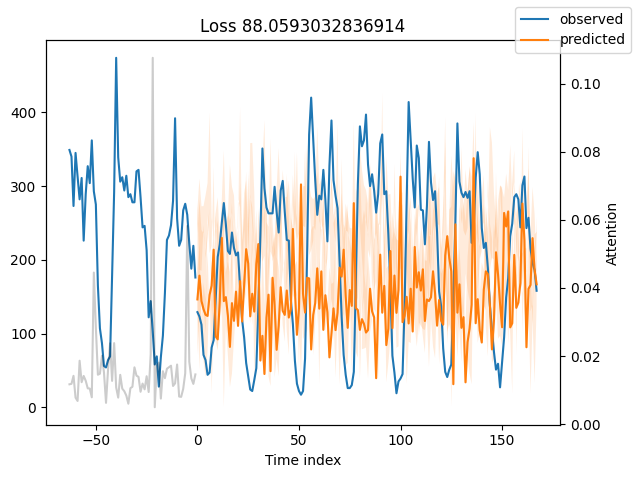

(scheduler +1m21s) Resized to 24 CPUs.


In [19]:
# TODO:  Why is there only 1 index instead of 3??
for idx in [0]:  # plot first 5 indexes (sort of a random sample)
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)